In [1]:
import sys
import numpy as np
sys.path.append("../")
from irradiance.models.kan_success import FastKANIrradiance
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import xarray as xr
from tqdm.notebook import tqdm

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
checkpoint_path = '/home/andres_munoz_j/megsai_runs/kan_baseline_mean.ckpt'
eve_norm = np.load('/mnt/disks/data-extended/preprocessed/EVE/EVS_MEGS-A_stats.npy')
uv_norm = np.load('/mnt/disks/data-extended/preprocessed/AIA_256_EVS_MEGS-AB_stats.npz', allow_pickle=True)['AIA'].item()
eve_data_db = xr.open_dataset('/mnt/disks/data-extended/preprocessed/EVE/EVS_MEGS-A_irradiance.nc')

aia_stack = np.load('/mnt/disks/data-extended/preprocessed/AIA_256/AIA_2014-03-11T00:00:03.npy')
aia_stack = (aia_stack-uv_norm['mean'][:,None,None])/uv_norm['std'][:,None,None]
aia_stack = torch.tensor(aia_stack)

In [3]:
eve_data_db

<xarray.Dataset> Size: 11GB
Dimensions:     (isoDate: 2055800, wavelength: 1377)
Coordinates:
  * isoDate     (isoDate) <U19 156MB '2010-05-20T00:01:04' ... '2014-05-10T00...
  * wavelength  (wavelength) float32 6kB 5.79 5.81 5.83 ... 33.27 33.29 33.31
Data variables:
    irradiance  (isoDate, wavelength) float32 11GB ...
Attributes:
    title:    EVE spectral irradiance

In [4]:
target_irradiance = eve_data_db.loc[dict(isoDate='2014-03-11T00:00:05')]
target_irradiance

<xarray.Dataset> Size: 11kB
Dimensions:     (wavelength: 1377)
Coordinates:
    isoDate     <U19 76B '2014-03-11T00:00:05'
  * wavelength  (wavelength) float32 6kB 5.79 5.81 5.83 ... 33.27 33.29 33.31
Data variables:
    irradiance  (wavelength) float32 6kB ...
Attributes:
    title:    EVE spectral irradiance

In [5]:
channel_wl = eve_data_db.coords['wavelength'].values

In [6]:
model_ckpt = torch.load(checkpoint_path)
model_ckpt

/var/tmp/ipykernel_181819/2164160910.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ckpt = torch.load(checkpoint_path)


{'epochs': 100,
 'lr': 0.0001,
 'seed': 3110,
 'architecture': 'kan',
 'val_months': [2, 3],
 'test_months': [11, 12],
 'holdout_months': [1, 10],
 'ln_epochs': 50,
 'ln_lr': 0.01,
 'cnn_model': 'efficientnet_b3',
 'cnn_lr': 0.0001,
 'cnn_dp': 0.0,
 'cnn_epochs': 50,
 '94': [0],
 '131': [1],
 '171': [2],
 '193': [3],
 '211': [4],
 '304': [5],
 '335': [6],
 '1600': [7],
 '1700': [8],
 'AIA': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'EUVI': [2, 3, 4, 5],
 'EUI': [2, 5],
 'SUVI': [0, 1, 2, 3, 4, 5],
 'CIRCE': [1, 3, 5],
 'model': FastKANIrradiance(
   (loss_func): HuberLoss()
   (layers): ModuleList(
     (0): FastKANLayer(
       (layernorm): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
       (rbf): RadialBasisFunction()
       (spline_linear): SplineLinear(in_features=72, out_features=1377, bias=False)
       (base_linear): Linear(in_features=9, out_features=1377, bias=True)
     )
   )
 ),
 'instrument': 'AIA'}

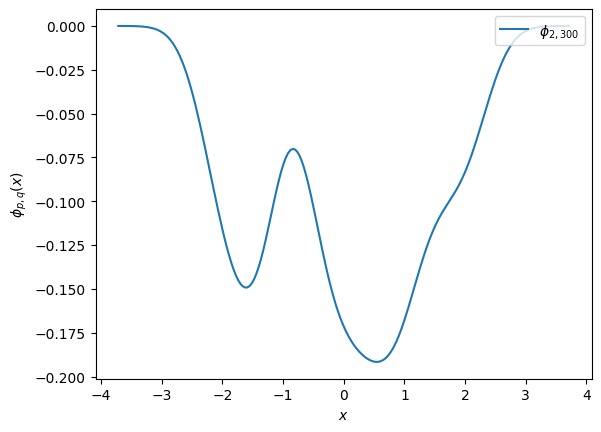

In [7]:
i=2
j=300
x, y = model_ckpt['model'].layers[0].plot_curve(i, j, 200, num_extrapolate_bins=3)
plt.plot(x.numpy(), y.numpy(), label=r"$\phi_{" + f"{i},{j}" + r"}$")
plt.xlabel("$x$")
plt.ylabel("$\phi_{p,q}(x)$")
plt.legend(loc="upper right")

In [8]:
with torch.no_grad():
    irradiance = model_ckpt['model'].forward_unnormalize(aia_stack[None,...].cpu()).squeeze()

Text(0, 0.5, 'Spectral Irradiance (W m$^{-2}$ nm$^{-1}$)')

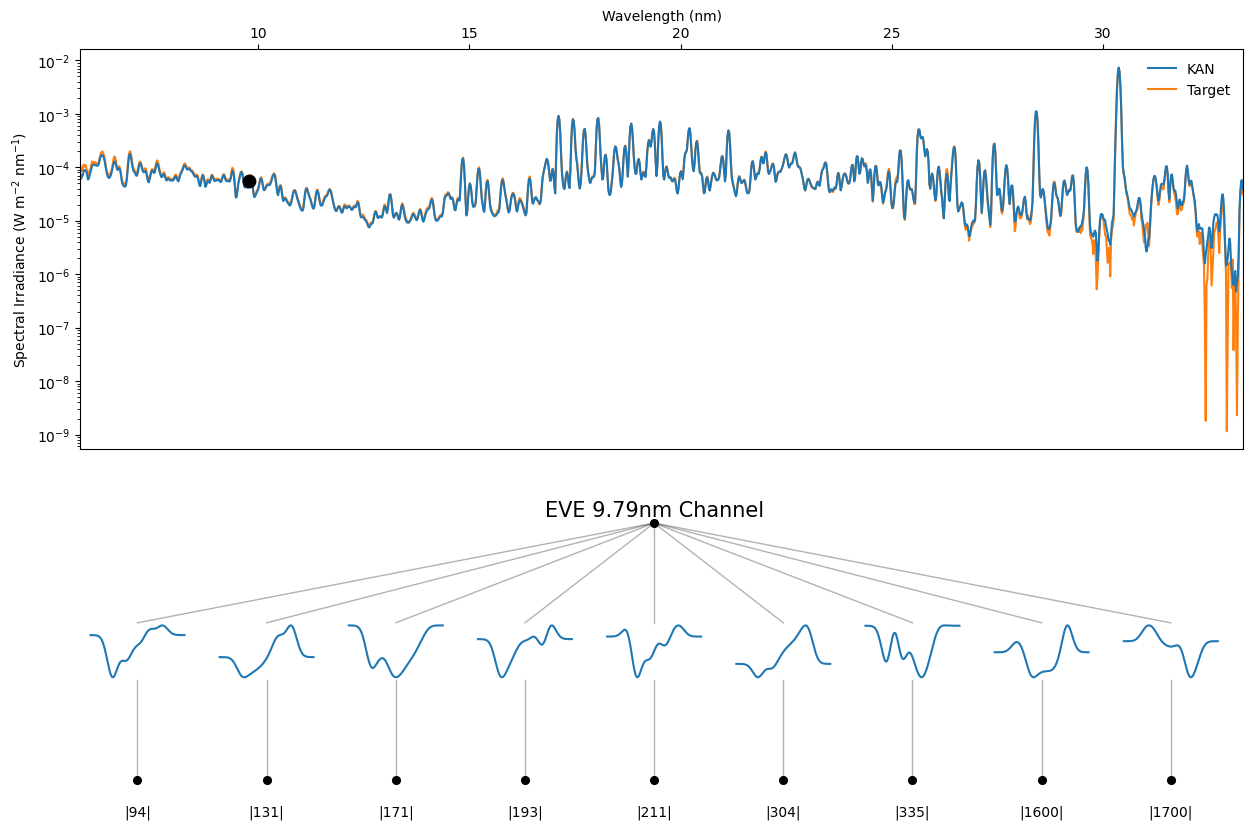

In [9]:
channel=200

A = 1
scale=0.5
neuron_depth = len(model_ckpt['model'].layers)+1
y0 = 0.4  # 0.4
mask=False

width = np.array([layer.input_dim for layer in model_ckpt['model'].layers]+[1])

min_spacing = A / np.maximum(np.max(width), 5)

max_num_weights = np.max(width)
y1 = 0.4 / np.maximum(max_num_weights, 3)

fig, ax = plt.subplots(figsize=(30 * scale, 10 * scale * (neuron_depth) * y0))


# plot scatters and lines
for l in range(neuron_depth):
    n = model_ckpt['model'].layers[l].input_dim if l < len(model_ckpt['model'].layers) else 1
    spacing = A / n
    for i in range(n):
        plt.scatter(1 / (2 * n) + i / n, l * y0, s=min_spacing ** 2 * 10000 * scale ** 2, color='black')

        if l < neuron_depth - 1:
            # plot connections
            n_next = width[l + 1]
            N = n * n_next
            for j in range(n_next):
                id_ = i * n_next + j
                color = "black"
                alpha_mask = .3

                if mask == True:
                    plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * y0, (l + 1 / 2) * y0 - y1], color=color, lw=2 * scale, alpha=alpha_mask)
                    plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [(l + 1 / 2) * y0 + y1, (l + 1) * y0], color=color, lw=2 * scale, alpha=alpha_mask)
                else:
                    plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * y0, (l + 1 / 2) * y0 - y1], color=color, lw=2 * scale, alpha=alpha_mask)
                    plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [(l + 1 / 2) * y0 + y1, (l + 1) * y0], color=color, lw=2 * scale, alpha=alpha_mask)

    plt.xlim(0, 1)
    plt.ylim(-0.1 * y0, (neuron_depth - 1 + 0.1) * y0)

plt.axis('off')

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

# plot splines
for l in range(neuron_depth - 1):
    n = width[l]
    for i in range(n):
        n_next = width[l + 1]
        N = n * n_next
        for j in range(n_next):
            id_ = i * n_next + j
            left = DC_to_NFC([1 / (2 * N) + id_ / N - y1, 0])[0]
            right = DC_to_NFC([1 / (2 * N) + id_ / N + y1, 0])[0]
            bottom = DC_to_NFC([0, (l + 1 / 2) * y0 - y1])[1]
            up = DC_to_NFC([0, (l + 1 / 2) * y0 + y1])[1]

            if l < len(model_ckpt['model'].layers):
                newax = fig.add_axes([left, bottom, right - left, up - bottom])
                # newax = fig.add_axes([1/(2*N)+id_/N-y1, (l+1/2)*y0-y1, y1, y1], anchor='NE')

                x, y = model_ckpt['model'].layers[l].plot_curve(i, channel, 200, num_extrapolate_bins=3)
                newax.plot(x.numpy(), y.numpy())

            newax.axis('off')


in_vars = ["|94|","|131|", "|171|", "|193|", "|211|", "|304|", "|335|", "|1600|", "|1700|", "s(94)","s(131)", "s(171)", "s(193)", "s(211)", "s(304)", "s(335)", "s(1600)", "s(1700)"]

n = model_ckpt['model'].layers[0].input_dim
for i in range(n):
    plt.gcf().get_axes()[0].text(1 / (2 * (n)) + i / (n), -0.05, in_vars[i], fontsize=20 * scale, horizontalalignment='center', verticalalignment='center')


title = f"EVE {channel_wl[channel]:.2f}nm Channel"
plt.gcf().get_axes()[0].text(0.5, y0 * (len(width) - 1) + 0.02, title, fontsize=30 * scale, horizontalalignment='center', verticalalignment='center')

offset = 0.03

left = 0.1 + offset
right = .875 + offset
bottom = 1
up = 2


irrax = fig.add_axes([left, bottom, right - left, up - bottom])
irrax.plot(channel_wl, irradiance, label='KAN')
irrax.plot(channel_wl, target_irradiance['irradiance'].values, label='Target', zorder=1)
irrax.scatter(channel_wl[channel], irradiance[channel], s=80, c='k', zorder=3)
irrax.set_yscale('log')
irrax.legend(frameon=False)
irrax.set_xlim([np.min(channel_wl), np.max(channel_wl)])

irrax.xaxis.tick_top()
irrax.set_xlabel('Wavelength (nm)')    
irrax.xaxis.set_label_position('top')

irrax.set_ylabel(r'Spectral Irradiance (W m$^{-2}$ nm$^{-1}$)')  


In [13]:
movie_path = '/home/andres_munoz_j/figures3'
stride = 3
for kk, channel in tqdm(enumerate(np.arange(0,irradiance.shape[0],stride)), total=np.arange(0,irradiance.shape[0],stride).shape[0]):

    A = 1
    scale=0.5
    neuron_depth = len(model_ckpt['model'].layers)+1
    y0 = 0.4  # 0.4
    mask=False

    width = np.array([layer.input_dim for layer in model_ckpt['model'].layers]+[1])

    min_spacing = A / np.maximum(np.max(width), 5)

    max_num_weights = np.max(width)
    y1 = 0.4 / np.maximum(max_num_weights, 3)

    fig, ax = plt.subplots(figsize=(30 * scale, 10 * scale * (neuron_depth) * y0))


    # plot scatters and lines
    for l in range(neuron_depth):
        n = model_ckpt['model'].layers[l].input_dim if l < len(model_ckpt['model'].layers) else 1
        spacing = A / n
        for i in range(n):
            plt.scatter(1 / (2 * n) + i / n, l * y0, s=min_spacing ** 2 * 10000 * scale ** 2, color='black')

            if l < neuron_depth - 1:
                # plot connections
                n_next = width[l + 1]
                N = n * n_next
                for j in range(n_next):
                    id_ = i * n_next + j
                    color = "black"
                    alpha_mask = .3

                    if mask == True:
                        plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * y0, (l + 1 / 2) * y0 - y1], color=color, lw=2 * scale, alpha=alpha_mask)
                        plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [(l + 1 / 2) * y0 + y1, (l + 1) * y0], color=color, lw=2 * scale, alpha=alpha_mask)
                    else:
                        plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * y0, (l + 1 / 2) * y0 - y1], color=color, lw=2 * scale, alpha=alpha_mask)
                        plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [(l + 1 / 2) * y0 + y1, (l + 1) * y0], color=color, lw=2 * scale, alpha=alpha_mask)

        plt.xlim(0, 1)
        plt.ylim(-0.1 * y0, (neuron_depth - 1 + 0.1) * y0)

    plt.axis('off')

    # -- Transformation functions
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

    # plot splines
    for l in range(neuron_depth - 1):
        n = width[l]
        for i in range(n):
            n_next = width[l + 1]
            N = n * n_next
            for j in range(n_next):
                id_ = i * n_next + j
                left = DC_to_NFC([1 / (2 * N) + id_ / N - y1, 0])[0]
                right = DC_to_NFC([1 / (2 * N) + id_ / N + y1, 0])[0]
                bottom = DC_to_NFC([0, (l + 1 / 2) * y0 - y1])[1]
                up = DC_to_NFC([0, (l + 1 / 2) * y0 + y1])[1]

                if l < len(model_ckpt['model'].layers):
                    newax = fig.add_axes([left, bottom, right - left, up - bottom])
                    # newax = fig.add_axes([1/(2*N)+id_/N-y1, (l+1/2)*y0-y1, y1, y1], anchor='NE')

                    x, y = model_ckpt['model'].layers[l].plot_curve(i, channel, 200, num_extrapolate_bins=3)
                    newax.plot(x.numpy(), y.numpy())

                newax.axis('off')


    in_vars = ["|94|","|131|", "|171|", "|193|", "|211|", "|304|", "|335|", "|1600|", "|1700|", "s(94)","s(131)", "s(171)", "s(193)", "s(211)", "s(304)", "s(335)", "s(1600)", "s(1700)"]

    n = model_ckpt['model'].layers[0].input_dim
    for i in range(n):
        plt.gcf().get_axes()[0].text(1 / (2 * (n)) + i / (n), -0.05, in_vars[i], fontsize=20 * scale, horizontalalignment='center', verticalalignment='center')


    title = f"EVE {channel_wl[channel]:.2f}nm Channel"
    plt.gcf().get_axes()[0].text(0.5, y0 * (len(width) - 1) + 0.02, title, fontsize=30 * scale, horizontalalignment='center', verticalalignment='center')

    offset = 0.03

    left = 0.1 + offset
    right = .875 + offset
    bottom = 1
    up = 2


    irrax = fig.add_axes([left, bottom, right - left, up - bottom])
    irrax.plot(channel_wl, irradiance, label='KAN')
    irrax.plot(channel_wl, target_irradiance['irradiance'].values, label='Target', zorder=1)
    irrax.scatter(channel_wl[channel], irradiance[channel], s=80, c='k', zorder=3)
    irrax.set_yscale('log')
    irrax.legend(frameon=False)
    irrax.set_xlim([np.min(channel_wl), np.max(channel_wl)])

    irrax.xaxis.tick_top()
    irrax.set_xlabel('Wavelength (nm)')    
    irrax.xaxis.set_label_position('top')

    irrax.set_ylabel(r'Spectral Irradiance (W m$^{-2}$ nm$^{-1}$)')

    fig.savefig(f'{movie_path}/activation' + '_'+ str(kk).zfill(4) + '.png', pad_inches=0, bbox_inches='tight') 
    plt.close(fig)


  0%|          | 0/459 [00:00<?, ?it/s]